# De Quoll classification pipeline

In deze tutorial wordt je stap voor stap wegwijs gemaakt in het toepassen van de Quoll classification pipeline voor tekstclassificatie. We gaan een classifier trainen in het identificeren van agressieve tweets en op verschillende manieren toepassen.

In tekstclassificatie wordt een machine learning algoritme getraind op het onderscheiden van verschillende typen teksten op basis van kenmerken in die teksten. Een van de meest gangbare en bruikbare kenmerken in de tekst zijn de (sequenties van) woorden. De quoll classification pipeline biedt modules waarmee deze kenmerken geëxtraheerd kunnen worden, en als input kan worden gegeven aan machine learning algoritmes. De term 'pipeline' verwijst naar de sequentie van afzonderlijke modules die daarbij doorlopen worden. Hieronder staat de structuur van de pipeline schematisch weergegeven:

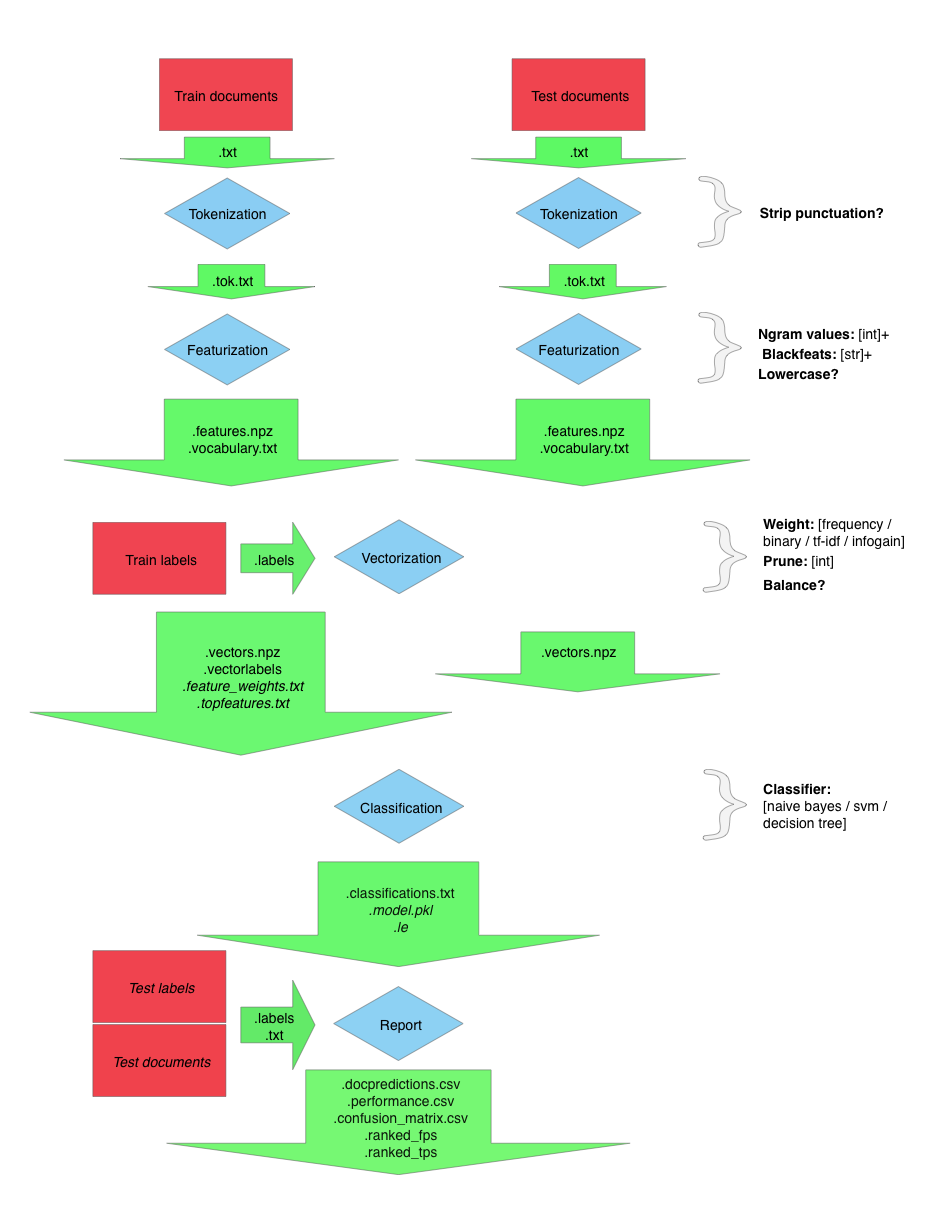

In [30]:
import os
import sys
sys.path.append('/home/vagrant/quoll/classification_pipeline/')
from IPython.display import Image
from IPython.core.display import HTML
Image(filename= "/home/vagrant/quoll/quoll_classification_scheme.png")

De pipeline is gebaseerd op verschillende libraries. 'Ucto' wordt bijvoorbeeld gebruikt voor het tokeniseren van Nederlandse teksten, en 'scikit-learn' wordt gebruikt voor de classificatie. Bij het toepassen van de pipeline merk je hier weinig van. De pipeline reguleert en monitort de input en output van afzonderlijke modules. Doordat iedere module uitgaat van een specifieke extensie van input en output bestanden, kan het in de gaten houden of ieder afzonderlijk proces succesvol verlopen is, of misschien al eerder doorlopen is omdat de output al aanwezig is. De pipeline kan 'bediend' worden vanuit de commandline, of vanuit python. In deze tutorial werken we voor het gemak met een python interface. Voor informatie over het gebruik van de commandline, zie https://github.com/LanguageMachines/LuigiNLP. 

Het enige wat voor de classificatie nodig is, zijn tekstdocumenten en labels om een classifier te trainen, en een tweede verzameling tekstdocumenten om de classifier op toe te passen. Mogelijk zijn voor deze tweede verzameling ook labels aanwezig, zodat de vaardigheid van de classifier om documenten aan de juiste labels te koppelen getest kan worden. 

De labels kunnen van alles zijn. Denk aan 'spam' - 'geen spam', 'positief' - 'negatief', 'man' - 'vrouw' of 'simpel' - 'ingewikkeld' - 'complex'. Vaak worden deze labels middels een (intensief) proces van annoteren vervaardigd, maar er zijn ook andere manieren. Hierop gaan we op deze plek niet in. We beginnen met groep van tekstdocumenten waarvoor de labels al beschikbaar zijn. Belangrijk voor de pipeline is dat deze bestanden <em>moeten</em> eindigen op respectievelijk '.txt' en '.labels'. 

In deze tutorial gaan we een classifier trainen om agressieve tweets te onderscheiden van niet-agressieve tweets. Hiervoor worden tweets gebruikt die al geannoteerd zijn. Om te beginnen zullen we ze inladen. De tweets en hun labels zijn gegeven in een specifieke directory. Alle modules die we gaan draaien schrijven nieuwe bestanden weg in deze directory. Omdat alle bestanden in deze directory komen te staan, bewaren we haar in een variabele:

In [ ]:
datadir_aggression = '/home/vagrant/quoll/classification_pipeline/tutorial/data/agressie/'
os.listdir(datadir_aggression)

In [ ]:
instances_aggression = datadir_aggression + 'train.txt'
labels_aggression = datadir_aggression + 'train.labels'
with open(instances_aggression,'r',encoding='utf-8') as infile:
    instances = infile.read().strip().split('\n')
with open(labels_aggression,'r',encoding='utf-8') as infile:
    labels = infile.read().strip().split('\n') 

Het bestand met tekstdocumenten (instanties) bevat op elke regel de tekst van een tweet: 

In [ ]:
print('\n'.join(instances[:10]))

Het bestand met labels bevat op elke regel een van de twee labels:

In [ ]:
print('\n'.join(labels[:10]))

Deze structuur is belangrijk, omdat de pipeline dit als input verwacht. De tweets en labels zijn met elkaar verbonden doordat ze dezelfde regel hebben. Beiden bestanden moeten daarom evenveel regels hebben:

In [ ]:
print(len(instances),'tweets,',len(labels),'labels')

Het aantal agressieve tweets en niet agressieve tweets is niet gelijk:

In [ ]:
print(labels.count('geen_agressie'),'keer geen_agressie,',labels.count('agressie'),'keer agressie.')

Op basis van deze distrubitie zal een classifier over het algemeen voorzichtiger zijn om een tweet als agressief te zien. 

Nu we de data hebben, kunnen we beginnen met het trainen en testen van een classifier. Eerst laden we de nodige scripts in:

In [ ]:
from modules.tokenize_instances import Tokenize
from modules.featurize_instances import Featurize
from modules.vectorize_sparse_instances import Vectorize, Vectorize_traintest
from modules.classify_instances import TrainApply
from modules.report_performance import ReportDocpredictionsComponent
from modules.run_nfold_cv_sparse import NFoldCV
from functions import docreader
import luiginlp

De meeste van deze scripts maken deel uit van de pipeline; de luiginlp library wordt gebruikt om de pipeline aan te spreken. 

We beginnen met het tokeniseren van de tekstbestanden. Hiervoor kan de module 'Tokenize' gebruikt worden. Een module vraagt om een bepaalde input, en eventueel om een of meerdere parameters. Dit staat weergegeven in het schema bovenaan deze tutorial. Ook kunnen we dit per module opvragen:

In [ ]:
Tokenize.get_param_names()[6:]

De 'config' parameter verwijst naar het configuratiebestand waarmee tokenisatie kan worden uitgevoerd. Omdat we met Nederlandse tweets werken gebruiken we het volgende configuratiebestand:

In [ ]:
tokconfig = '/etc/ucto/tokconfig-nl-twitter'

'Strip_punctuation' betreft de keuze om punctuatie te verwijderen, en niet mee te nemen als kenmerk voor classificatie. In ons geval zou punctuatie iets kunnen zeggen over de agressie in een tweet. Veel uitroeptekens bijvoorbeeld. We kunnen er ook voor kiezen om deze weg te laten, en te focussen op de taal. Hier kun je zelf een keuze in maken. 

Alle modules worden aangeroepen via de functie 'luiginlp.run'. Tussen haakjes wordt vervolgens de module gegeven, een daarbinnen de waarden van de parameters. Het bestand met tekstdocumenten wordt gegeven achter het standaardargument 'inputfile'. 

In [ ]:
luiginlp.run(Tokenize(inputfile=instances_aggression,tokconfig=tokconfig,strip_punctuation=True))

Als het tokeniseren succesvol is verlopen, is er een nieuw bestand met de extensie '.tok.nl' toegevoegd aan de directory:

In [ ]:
os.listdir(datadir_aggression)

Het nieuwe bestand ziet er hetzelfde uit als het originele bestand, met de uitzondering dat worden die gekoppeld waren aan een leesteken hier nu los van staan en, als hier voor gekozen is, leestekens zijn verwijderd: 

In [ ]:
tokenized = datadir_aggression + 'train.tok.txt'
with open(tokenized) as infile:
    lines = infile.read().split('\n')
    print(lines[:10])

De volgende stap is om bruikbare tekstkenmerken (features) uit de getokeniseerde documenten te halen. Hiervoor wordt de module 'Featurize' gebruikt:

In [ ]:
Featurize.get_param_names()[6:]

Wellicht valt je op dat deze module twee mogelijke inputparameters heeft die ook al in de tokenisatiemodule voorkwamen. De reden hiervoor is dat je met 'Featurize' tevens de tokenisatiemodule kan toepassen, als de input '.txt' is en niet '.tok.txt'. In ons geval hoeven we alleen de nieuwe parameters mee te geven. Via 'token_ngrams' kan de lengte van n-grammen opgegeven worden, standaard is dit een mix van 1-, 2- en 3-grammen, door cijfers onderbroken door een spatie in te voeren. Via 'blackfeats' kunnen woorden gegeven worden die moeten uitgesloten worden als tekstkenmerk. Dit is bijvoorbeeld handig bij woorden die als zoekwoord gebruikt zijn. Ook hier kunnen meerdere woorden ingevoerd worden door ze de onderbreken met een spatie. Tot slot kan ervoor gekozen worden om alle hoofdletters in kleine letters te veranderen, via 'lowercase' (opties: True/False). Het commando staat hieronder weergegeven. Alvorens de module te starten kun je de parameterwaarden naar keuze aanpassen:

In [ ]:
luiginlp.run(Featurize(inputfile=tokenized,token_ngrams='1 2 3',blackfeats=False,lowercase=False))

Op basis van deze module zijn de gewenste tekstkenmerken geëxtraheerd, geteld en als vector gerepresenteerd. Ieder tekstkenmerk correspondeert met een kolom in de vector. Deze kolommen zijn weergegeven in het bestand met de extensie 'vocabulary.txt'.

In [ ]:
featurized = datadir_aggression + 'train.features.npz'
vocabulary = datadir_aggression + 'train.vocabulary.txt'
with open(vocabulary,'r',encoding='utf-8') as infile:
    features = infile.read().split('\n')
    print(features[:20])

Vanaf de volgende stap wordt onderscheid gemaakt tussen een train- en een testbestand. Bij het trainen wordt gebruik gemaakt van labels, waarmee tekstkenmerken worden gewogen en een classificeermodel wordt getraind. De mogelijke labels van een testdocument worden enkel gebruikt bij het beoordelen van de beschikbare classifier. Hoewel we geen tweede bestand hebben met dezelfde labels, kunnen we het bestand dat we hebben in een train en een testset splitsen. Conventioneel wordt 90% gebruikt voor trainen en 10% voor testen. Omdat de geselecteerde bestande invloed kunnen hebben op de uitkomst, wordt deze split vaak tien keer gedaan, waarbij steeds getest wordt op een ander deel van de dataset. In de quoll pipeline wordt deze optie ook aangeboden, middels de module 'NFoldCV'.

In deze module wordt de dataset 'n' maal gesplitst in een training en testset, waarna de modules 'Vectorize', 'ClassifyTrainTest' en 'Report' doorlopen worden. Daarmee vraagt deze module om veel bestanden en parameters:

In [ ]:
NFoldCV.get_param_names()[3:]

De features, labels en vocabulary hebben we reeds gegenereert of hadden we al aan het begin. De 'n' parameter geeft het aantal splits. 'weight', 'prune' en 'balance' hebben betrekking op het vectoriseren. 

Met 'weight' kan bepaald worden hoe het gewicht van de tekstkenmerken gegeveb wordt, met de keuzen 'frequency' (het aantal keer dat een kenmerk in een tekst voorkomt), 'binary' (of een kenmerk voor komt, 1 of 0), 'infogain' en 'tf-idf'. De laatste twee wegingen kijken naar de verhouding tussen labels en tekstkenmerken en geven een hogere weging aan tekstkenmerken die sterk gekoppeld zijn aan een specifiek label. 

Met 'prune' kan het aantal tekstkenmerken gereduceerd worden, door de kenmerken te rangschikken op de hoogte van hun gewicht (of het aantal keer dat ze voorkomen in het geval van 'frequency' of 'binary'), en de kenmerken lager dan een gekozen rangschikking te verwijderen. Dit versnelt het proces vaak behoorlijk, terwijl het de prestaties nauwelijks aantast. Een gangbare waarde hiervoor is 5000. 

met 'balance' kan gekozen worden voor een gelijk aantal tekstdocumenten per label. In ons geval zijn er een stuk meer documenten met het label 'niet_agressief', dus dit kan een keuze zijn. Nadeel is wel dat er dan een hoop geannoteerde documenten weggegooid worden, wat natuurlijk zonde is. 

Met 'classifier' parameter kan het type classifier gekozen worden. Op dit moment zijn 'naive_bayes' en 'svm' de beschikbare classifier. Met name SVM kan ingesteld worden met eigen parameter settings. Deze kunnen meegegeven worden met 'classifier_args'. Als dit niet gedaan wordt voor SVM, zal het systeem zelf op zoek gaan naar de beste settings. Dit duurt echter vrij lang, dus is voor deze tutorial niet aan te raden. 

Met 'documents', tot slot, kunnen de originele tekstdocumenten meegegeven worden. Hiermee kunnen de classificaties gekoppeld worden aan de tekst. 

Hieronder staat het commando voor 'NFoldCV' klaar. Nadat je de parameters hebt bekeken / bijgesteld, kan het worden gestart. Hou er rekening mee dat dit even kan duren. 

In [ ]:
luiginlp.run(NFoldCV(features=instances_featurized,vocabulary=instances_vocabulary,labels=labels_aggression,n=10,weight='binary',prune=5000,balance=False,classifier='svm',classifier_args='1.0 linear 0.128 1',documents=instances_aggression))

Je kunt het experiment meerdere keren uitvoeren met verschillende settings. Voor iedere setting wordt een nieuwe directory aangemaakt, te herkennen aan een lange extensie beginnende met '10fold_cv' (of een andere extensie naar gelang je gekozen 'n').

Je kunt de resultaten bekijken per fold, en in totaal. De classifier is gescoord met de 'F-score' (op een schaal van 0-1, per klasse en in totaal), weergegeven in het bestand met de extensie .performance.csv'. Je kunt deze zelf inlezen met python, of via de command lijn via 'cat [naam van het bestand]'

Nu we de hele pipeline doorlopen hebben en getest hoe goed de classifier agressie herkent, kunnen we het gaan toepassen op een nieuwe dataset. Laten we kijken in hoeverre er agressief getweet is tijdens koninginnedag 2013. We laden eerst bestand in:

In [ ]:
datadir_koninginnedag = '/home/vagrant/quoll/classification_pipeline/tutorial/data/koninginnedag2013/'
instances_koninginnedag = datadir_koninginnedag + 'koninginnedag2013.txt'

We beginnen weer met tokeniseren en het extraheren van tekstkenmerken. Het is een behoorlijk groot bestand, dus dit kost ook even tijd:

In [ ]:
# OPDRACHT: pas 'Tokenize' en 'Featurize' toe op 'instances_koninginnedag', dit kan in twee stappen of in één stap. 
# !Belangrijk: zorg dat de parameterwaarden identiek zijn aan de waarden die voor de training dataset zijn gebruikt,
# als dit niet zo is zal de classifier minder effectief zijn. 
# !Belangrijk2: mogelijk is het bestand 'instances_koninginnedag' te groot voor het geheugen. Gebruik in dat geval 
# instances_koninginnedag_small
luiginlp.run(Featurize(inputfile=instances_koninginnedag,token_ngrams='1 2 3',blackfeats=False,lowercase=False,tokconfig=tokconfig,strip_punctuation=True))

Als het gelukt is staat er nu een bestand met alle tekstkenmerken en met vectoren in de directory: 

In [ ]:
koninginnedag_features = datadir_koninginnedag + 'koninginnedag2013.features.npz'
koninginnedag_vocabulary = datadir_koninginnedag + 'koninginnedag2013.vocabulary.txt'

Nu we de tekstkenmerken hebben geëxtraheerd, kunnen we een classifier trainen op de tweets die reeds zijn gelabeld met 'aggresief' of 'niet_agressief', en testen op de ongelabelde tweets. Dit vraagt om behoorlijk wat bestanden als invoer:

In [ ]:
luiginlp.run(Vectorize_traintest(trainfile=featurized,trainlabels_file=labels_aggression,trainvocabulary=vocabulary,weight='binary',prune='5000',balance=False,testfile=koninginnedag_features,testvocabulary=koninginnedag_vocabulary))

Vervolgens gaan we een classifier trainen en toepassen. Ook dit kan even duren. 

In [ ]:
vectors_aggression = datadir_aggression + 'train.vectors.npz'
vectorlabels_aggression = datadir_aggression + 'train.vectorlabels'
vectors_koninginnedag = datadir_koninginnedag + 'koninginnedag2013.vectors.npz'

In [ ]:
luiginlp.run(TrainApply(trainvectors=vectors_aggression,trainlabels=vectorlabels_aggression,testvectors=vectors_koninginnedag,classifier='svm',classifier_args='1.0 linear 0.128 1'))

Tot slot komt het leuke gedeelte, waarin we kunnen bekijken welke tweets als agressief uit de bus zijn gekomen. We hebben de classificaties al, dus hoeven deze alleen nog maar te koppelen aan de originele tekstdocumenten. 

In [ ]:
classifications_koninginnedag = datadir_koninginnedag + 'koninginnedag2013.classifications.txt'

In [ ]:
luiginlp.run(ReportDocpredictionsComponent(predictions=classifications_koninginnedag,documents=instances_koninginnedag))

In [ ]:
dr = docreader.Docreader()
docpredictions=dr.parse_csv('/home/vagrant/quoll/classification_pipeline/tutorial/data/koninginnedag2013/koninginnedag2013.docpredictions.csv')
aggressives = [doc for doc in docpredictions if doc[2] == 'agressie']
print(len(docpredictions),len(aggressives))

In [ ]:
sorted_aggressives = sorted(aggressives,key = lambda k : k[3], reverse=True)
print('\n'.join(['\t'.join((sa[0],sa[3])) for sa in sorted_aggressives[:50]]))